In [68]:
#Detecting credit card fraud cases using Naive Bayes algorithm 

#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,auc,roc_auc_score
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

In [69]:
#Load data
df = pd.read_csv("C:\\Users\\sagi\\Desktop\\Learning\\ML\\Datasets\\creditcard.csv")

In [70]:
#Explore data
print(df.shape)

print("First 6 lines:")
print(df.head())

print("describe: ")
print(df.describe())

print("info: ")
print(df.info())

(284807, 31)
First 6 lines:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...         V21       V22       V23       V24  \
0  0.098698  0.363787  ...   -0.018307  0.277838 -0.110474  0.066928   
1  0.085102 -0.255425  ...   -0.225775 -0.638672  0.101288 -0.339846   
2  0.247676 -1.514654  ...    0.247998  0.771679  0.909412 -0.689281   
3  0.377436 -1.387024  ...   -0.108300  0.005274 -0.190321 -1.175575   
4 -0.270533  0.817739  ...   -0.009431  0.798278 -0.137458  0.141267   

        V25       V26       V27       V28  Amount  C

([<matplotlib.patches.Wedge at 0x3b37d007b8>,
 [Text(-1.09998380137016, 0.0059696501784341355, 'Genuine'),
  Text(1.0999838018177286, -0.005969567707642625, 'Fraud')],
 [Text(-0.5999911643837235, 0.0032561728246004373, '99.8%'),
  Text(0.5999911646278518, -0.0032561278405323405, '0.2%')])

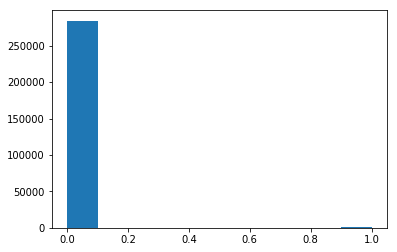

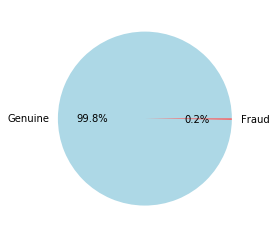

In [71]:
#Histogram
plt.hist(df.Class)

#Pie Chart
fig, ax = plt.subplots(1, 1)
ax.pie(df.Class.value_counts(),autopct='%1.1f%%', labels=['Genuine','Fraud'], colors=['LightBlue','r'])

284802    47.996111
284803    47.996389
284804    47.996667
284805    47.996667
284806    47.997778
Name: Time_Hr, dtype: float64


Text(0, 0.5, '# transactions')

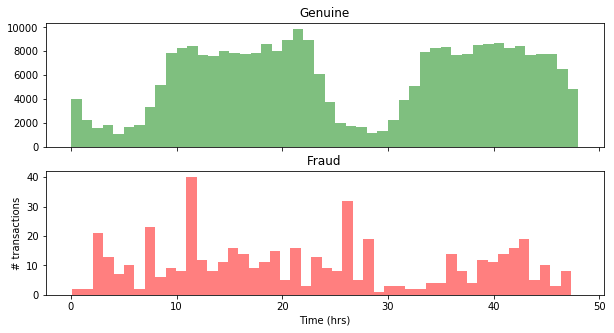

In [72]:
#Finding tends with "time" 
df["Time_Hr"] = df["Time"]/3600 # convert to hours
print(df["Time_Hr"].tail())
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, figsize=(10,5))
ax1.hist(df.Time_Hr[df.Class==0],bins=48,color='g',alpha=0.5)
ax1.set_title('Genuine')
ax2.hist(df.Time_Hr[df.Class==1],bins=48,color='r',alpha=0.5)
ax2.set_title('Fraud')
plt.xlabel('Time (hrs)')
plt.ylabel('# transactions')

In [36]:
#looks like "time" does not appear to have much predicive power to detect fraud in this dataset (I will check it again later)
df = df.drop(['Time'],axis=1)

Text(0, 0.5, '# transactions')

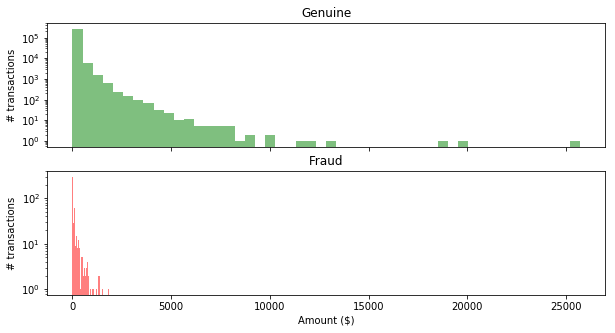

In [37]:
#Amount and # of transactions
fig, (ax3,ax4) = plt.subplots(2,1, figsize = (10,5), sharex = True)
ax3.hist(df.Amount[df.Class==0],bins=50,color='g',alpha=0.5)
ax3.set_yscale('log') # to see the tails
ax3.set_title('Genuine') # to see the tails
ax3.set_ylabel('# transactions')
ax4.hist(df.Amount[df.Class==1],bins=50,color='r',alpha=0.5)
ax4.set_yscale('log') # to see the tails
ax4.set_title('Fraud') # to see the tails
ax4.set_xlabel('Amount ($)')
ax4.set_ylabel('# transactions')

In [38]:
#Looks like that all of the fraud cases were transactions of <$5000
#Scaling the amount
from sklearn.preprocessing import StandardScaler
df['scaled_Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1,1))
df = df.drop(['Amount'],axis=1)

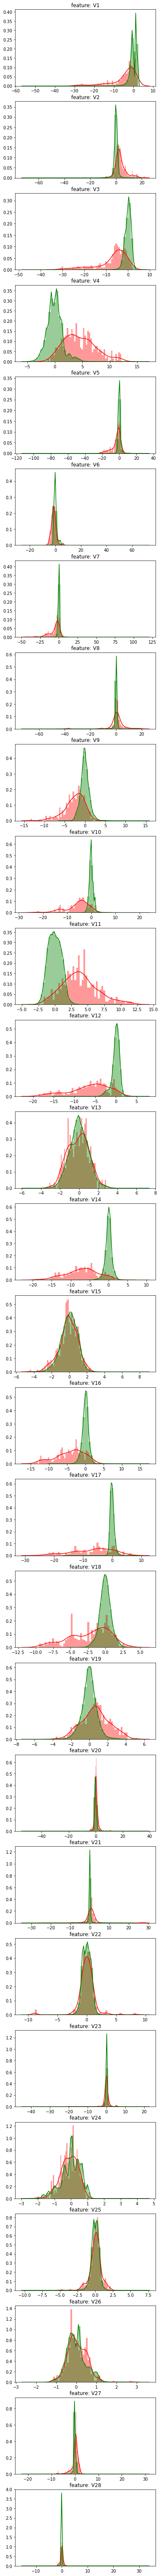

In [39]:
#Checking correlations
import seaborn as sns
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(28, 1)
plt.figure(figsize=(6,28*4))
for i, col in enumerate(df[df.iloc[:,0:28].columns]):
    ax5 = plt.subplot(gs[i])
    sns.distplot(df[col][df.Class == 1], bins=50, color='r')
    sns.distplot(df[col][df.Class == 0], bins=50, color='g')
    ax5.set_xlabel('')
    ax5.set_title('feature: ' + str(col))
plt.show()

In [54]:
#Looks like some of the features have similar distribution.

#Define a function to split the data- we will use it soon
def split_data(df, drop_list):
    df = df.drop(drop_list,axis=1)
    print(df.columns)
    #test train split time
    from sklearn.model_selection import train_test_split
    y = df['Class'].values #target
    X = df.drop(['Class'],axis=1).values #features
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, stratify=y)

    print("train-set size: ", len(y_train),
      "\ntest-set size: ", len(y_test))
    print("fraud cases in test-set: ", sum(y_test))
    return X_train, X_test, y_train, y_test

#Define a function to predict
def get_predictions(clf, X_train, y_train, X_test):
    # create classifier
    clf = clf
    # fit it to training data
    clf.fit(X_train,y_train)
    # predict using test data
    y_pred = clf.predict(X_test)
    # Compute predicted probabilities: y_pred_prob
    y_pred_prob = clf.predict_proba(X_test)
    #for fun: train-set predictions
    train_pred = clf.predict(X_train)
    print('train-set confusion matrix:\n', confusion_matrix(y_train,train_pred))
    return y_pred, y_pred_prob

#Define a function to print the classifier's scores
def print_scores(y_test,y_pred,y_pred_prob):
    print('test-set confusion matrix:\n', sns.heatmap(confusion_matrix(y_test,y_pred),annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0))
    print("recall score: ", recall_score(y_test,y_pred))
    print("precision score: ", precision_score(y_test,y_pred))
    print("f1 score: ", f1_score(y_test,y_pred))
    print("accuracy score: ", accuracy_score(y_test,y_pred))
    print("ROC AUC: {}".format(roc_auc_score(y_test, y_pred_prob[:,1])))

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Class', 'Time_Hr',
       'scaled_Amount'],
      dtype='object')
train-set size:  227845 
test-set size:  56962
fraud cases in test-set:  98
train-set confusion matrix:
 [[222480   4971]
 [    69    325]]
test-set confusion matrix:
 AxesSubplot(0.125,0.125;0.62x0.755)
recall score:  0.8469387755102041
precision score:  0.058781869688385266
f1 score:  0.10993377483443707
accuracy score:  0.9764053228468101
ROC AUC: 0.963247971529636


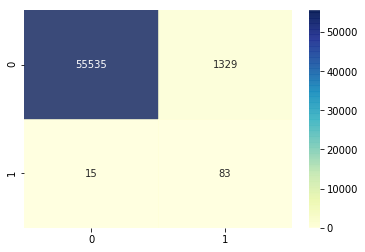

In [55]:
#Checking a few cases

# Case-NB-1 : not dropping anything
drop_list = []
X_train, X_test, y_train, y_test = split_data(df, drop_list)
y_pred, y_pred_prob = get_predictions(GaussianNB(), X_train, y_train, X_test)
print_scores(y_test,y_pred,y_pred_prob)

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12',
       'V14', 'V16', 'V17', 'V18', 'V19', 'V21', 'Class', 'Time_Hr',
       'scaled_Amount'],
      dtype='object')
train-set size:  227845 
test-set size:  56962
fraud cases in test-set:  98
train-set confusion matrix:
 [[223967   3484]
 [    61    333]]
test-set confusion matrix:
 AxesSubplot(0.125,0.125;0.62x0.755)
recall score:  0.8775510204081632
precision score:  0.08472906403940887
f1 score:  0.15453728661275834
accuracy score:  0.9834802148800955
ROC AUC: 0.9622034097825962


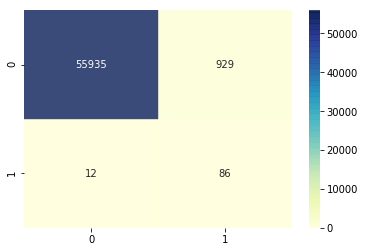

In [56]:
# Case-NB-2 : dropping some features that had similar distributions
drop_list = ['V28','V27','V26','V25','V24','V23','V22','V20','V15','V13','V8']
X_train, X_test, y_train, y_test = split_data(df, drop_list)
y_pred, y_pred_prob = get_predictions(GaussianNB(), X_train, y_train, X_test)
print_scores(y_test,y_pred,y_pred_prob)

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12',
       'V14', 'V16', 'V17', 'V18', 'V19', 'V21', 'Class', 'scaled_Amount'],
      dtype='object')
train-set size:  227845 
test-set size:  56962
fraud cases in test-set:  98
train-set confusion matrix:
 [[223964   3487]
 [    60    334]]
test-set confusion matrix:
 AxesSubplot(0.125,0.125;0.62x0.755)
recall score:  0.8775510204081632
precision score:  0.08481262327416174
f1 score:  0.15467625899280577
accuracy score:  0.9834977704434535
ROC AUC: 0.9613612643988377


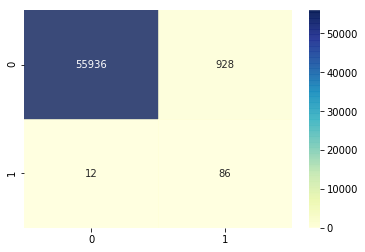

In [57]:
#Looks like that reducing the similar features helps the model
# Case-NB-3 : dropping some features + Time 
drop_list = ['Time_Hr','V28','V27','V26','V25','V24','V23','V22','V20','V15','V13','V8']
X_train, X_test, y_train, y_test = split_data(df, drop_list)
y_pred, y_pred_prob = get_predictions(GaussianNB(), X_train, y_train, X_test)
print_scores(y_test,y_pred,y_pred_prob)

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12',
       'V14', 'V16', 'V17', 'V18', 'V19', 'V21', 'Class'],
      dtype='object')
train-set size:  227845 
test-set size:  56962
fraud cases in test-set:  98
train-set confusion matrix:
 [[224025   3426]
 [    60    334]]
test-set confusion matrix:
 AxesSubplot(0.125,0.125;0.62x0.755)
recall score:  0.8775510204081632
precision score:  0.08634538152610442
f1 score:  0.15722120658135283
accuracy score:  0.9838137705838981
ROC AUC: 0.9611556179872063


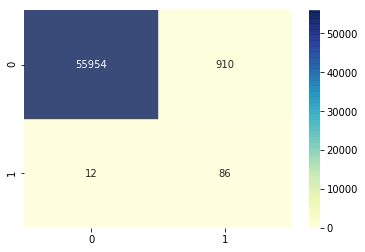

In [58]:
#Looks like "Time_Hr" is not helping much in classification
# Case-NB-4 : dropping some features + Time + 'scaled_Amount'
drop_list = ['scaled_Amount','Time_Hr','V28','V27','V26','V25','V24','V23','V22','V20','V15','V13','V8']
X_train, X_test, y_train, y_test = split_data(df, drop_list)
y_pred, y_pred_prob = get_predictions(GaussianNB(), X_train, y_train, X_test)
print_scores(y_test,y_pred,y_pred_prob)

In [59]:
#Looks like case NB-4 gives a better model. 
#dropping some redundant feature
df = df.drop(drop_list,axis=1)
print(df.columns)

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12',
       'V14', 'V16', 'V17', 'V18', 'V19', 'V21', 'Class'],
      dtype='object')


c:\users\sagi\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


train-set confusion matrix:
 [[227423     28]
 [   167    227]]
test-set confusion matrix:
 AxesSubplot(0.125,0.125;0.62x0.755)
recall score:  0.5612244897959183
precision score:  0.8088235294117647
f1 score:  0.6626506024096385
accuracy score:  0.9990168884519505
ROC AUC: 0.9747864220251972


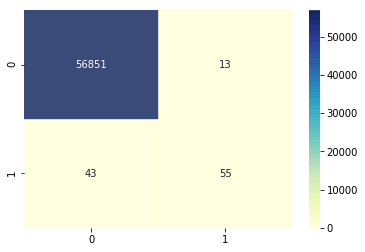

In [61]:
#I believe we can do better so we'll try another classifier (just for fun)
#Logistic Regression

# Case-LR-1
y_pred, y_pred_prob = get_predictions(LogisticRegression(C = 0.01, penalty = 'l1')
                                      , X_train, y_train, X_test)
print_scores(y_test,y_pred,y_pred_prob)

In [62]:
#Since this dataset is imbalanced, let's try to use LR with under-sampled data

# get indices for fraud and genuine classes 
fraud_ind = np.array(df[df.Class == 1].index)
gen_ind = df[df.Class == 0].index
n_fraud = len(df[df.Class == 1])
# random selection from genuine class
random_gen_ind = np.random.choice(gen_ind, n_fraud, replace = False)
random_gen_ind = np.array(random_gen_ind)
# merge two class indices: random genuine + original fraud
under_sample_ind = np.concatenate([fraud_ind,random_gen_ind])
# Under sample dataset
undersample_df = df.iloc[under_sample_ind,:]
y_undersample  = undersample_df['Class'].values #target
X_undersample = undersample_df.drop(['Class'],axis=1).values #features

print("# transactions in undersampled data: ", len(undersample_df))
print("% genuine transactions: ",len(undersample_df[undersample_df.Class == 0])/len(undersample_df))
print("% fraud transactions: ", sum(y_undersample)/len(undersample_df))

# transactions in undersampled data:  984
% genuine transactions:  0.5
% fraud transactions:  0.5


Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12',
       'V14', 'V16', 'V17', 'V18', 'V19', 'V21', 'Class'],
      dtype='object')
train-set size:  787 
test-set size:  197
fraud cases in test-set:  98
train-set confusion matrix:
 [[374  19]
 [ 35 359]]
test-set confusion matrix:
 AxesSubplot(0.125,0.125;0.62x0.755)
recall score:  0.9591836734693877
precision score:  0.9690721649484536
f1 score:  0.964102564102564
accuracy score:  0.9644670050761421
ROC AUC: 0.9846423417851989


c:\users\sagi\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


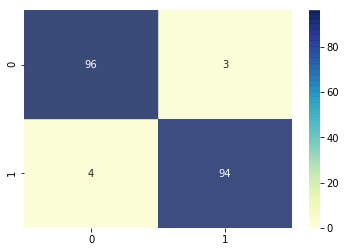

In [63]:
# Case-LR-2
# split undersampled data into 80/20 train-test datasets. 
# - Train model from this 80% fraction of undersampled data, get predictions from left over i.e. 20%.
drop_list = []
X_und_train, X_und_test, y_und_train, y_und_test = split_data(undersample_df, drop_list)
y_und_pred, y_und_pred_prob = get_predictions(LogisticRegression(C = 0.01, penalty = 'l1'), X_und_train, y_und_train, X_und_test)
print_scores(y_und_test,y_und_pred,y_und_pred_prob)

In [64]:
#Looks way better

#checking performance for the full skewed dataset
# Case-LR-3
# "train" with undersamples, "test" with full data
# call classifier
lr = LogisticRegression(C = 0.01, penalty = 'l1')
# fit it to complete undersampled data
lr.fit(X_undersample, y_undersample)
# predict on full data
y_full = df['Class'].values #target
X_full = df.drop(['Class'],axis=1).values #features
y_full_pred = lr.predict(X_full)
# Compute predicted probabilities: y_pred_prob
y_full_pred_prob = lr.predict_proba(X_full)
print("scores for Full set")   
print('test-set confusion matrix:\n', confusion_matrix(y_full,y_full_pred)) 
print("recall score: ", recall_score(y_full,y_full_pred))
print("precision score: ", precision_score(y_full,y_full_pred))


c:\users\sagi\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


scores for Full set
test-set confusion matrix:
 [[277315   7000]
 [    48    444]]
recall score:  0.9024390243902439
precision score:  0.05964535196131112


In [66]:
#comparing the scores from Gaussian NB with lR

# Case-LR-4
y_p20_pred = lr.predict(X_test)
y_p20_pred_prob = lr.predict_proba(X_test)
print("scores for test (20% of full) set")   
print('test-set confusion matrix:\n', confusion_matrix(y_test,y_p20_pred)) 
print("recall score: ", recall_score(y_test,y_p20_pred))
print("precision score: ", precision_score(y_test,y_p20_pred))

scores for test (20% of full) set
test-set confusion matrix:
 [[55387  1477]
 [    8    90]]
recall score:  0.9183673469387755
precision score:  0.0574345883854499


In [67]:
'''
NB vs LR recall score of 0.878 vs 0.929.

NB confusion matrix:

[[55954 910] [ 12 86]]

LR confusion matrix:

[[53547 3317] [ 7 91]]

Conclusion: LR gives better model sensitivity. Though, the positive predictive value for NB is higher.
We can probably improve NB's performance by changing the default threshold on calculated probabilities.
Though, 89% of fraud cases are detected. Not bad for a simple model. 
'''

"\nNB vs LR recall score of 0.878 vs 0.929.\n\nNB confusion matrix:\n\n[[55954 910] [ 12 86]]\n\nLR confusion matrix:\n\n[[53547 3317] [ 7 91]]\n\nConclusion: LR gives better model sensitivity. Though, the positive predictive value for NB is higher.\nWe can probably improve NB's performance by changing the default threshold on calculated probabilities.\nThough, 89% of fraud cases are detected. Not bad for a simple model. \n"